In [1]:
import csv
import html
import re
from collections import Counter
from datetime import datetime

import mariadb
import matplotlib.pyplot as plt
import squarify
import unidecode

In [2]:
def decode2(s):
    t = unidecode.unidecode(s)
    if t == "[?]":
        return "_"
    else:
        return t


def decodeStr(s):
    t = ""
    for x in s:
        t = t + decode2(x)
    return t


def clean_work(s):
    s = html.unescape(s)
    s = decodeStr(s)  # convert foreign language to bad-english
    skips = re.compile(r"[^\x00-\x7F]")  # get rid of anything non-ascii
    s = re.sub(skips, " ", s)
    s = re.sub("  ", " ", s)
    s = s.replace("\t", " ")
    s = s.replace("\n", " ")
    s = s.replace("'", " ")  # get rid of single quotes
    s = s.replace('"', " ")  # get rid of double quotes
    s = s.replace("  ", " ")  # get rid of extra spaces
    return s.strip()


def clean17(s):
    s = clean_work(s)
    t = clean_work(s)
    while s != t:
        s = t
        t = clean_work(s)
    return s.lower()

### 1. (Part A) Standardizing the date-time in YYYY-MM-DD HH:MM format. 

In [3]:
def convert_date(date: str) -> str:
    return datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y").strftime("%Y-%m-%d %H:%M")

In [4]:
def wrangle_row(row: list) -> dict:
    data: dict = {
        "tweet_date": convert_date(row[0]),
        "tweet_id": row[1],
        "tweet": clean17(row[2]),
        "handle": row[4],
    }
    data["retweet"] = True if data["tweet"].startswith("rt ") else False
    return data

In [5]:
# print first 10 rows with standardized date-time
with open(r"randomTweets.txt") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter="\t")
    for i, row in enumerate(csv_reader):
        data = wrangle_row(row)
        print("{i}: {d}".format(i=i + 1, d=data))
        if i >= 9:
            break

1: {'tweet_date': '2020-07-25 04:43', 'tweet_id': '1286884650187718656', 'tweet': 'rt @platinumjab: shiv is the seed of the seed of the seed. shiv is the first seed. shiv is the beginning of the beginning of the beginnin', 'handle': 'Vijaykant087', 'retweet': True}
2: {'tweet_date': '2020-07-25 04:43', 'tweet_id': '1286884650175074304', 'tweet': 'rt @catvalente: every millennial i know is locked in their house doomscrolling & baking bread while their parents think masks are poisonous', 'handle': 'AndaliteBandit', 'retweet': True}
3: {'tweet_date': '2020-07-25 05:06', 'tweet_id': '1286890539359416321', 'tweet': 'rt @ghettofabulos0: candy - partynextdoor x nipsey hussle. thats the tweet.', 'handle': 'reignofmaya', 'retweet': True}
4: {'tweet_date': '2020-07-25 05:06', 'tweet_id': '1286890539355459586', 'tweet': 'rt @realjameswoods: #ripbernelltremmell // this hate crime isnt getting much attention from the democrat propaganda machine, but im hopin', 'handle': 'BrojackNorseman', 'retweet'

### 1. (Part B) Rebuilding the table.

In [6]:
connection = mariadb.connect(
    host="127.0.0.1", user="root", database="tweets", autocommit=True
)
cursor = connection.cursor()

In [7]:
cursor.execute("DROP TABLE IF EXISTS tweets")
cursor.execute(
    "CREATE TABLE tweets(tweet_id BIGINT, tweet_date DATETIME, tweet TEXT, handle TINYTEXT, retweet BOOLEAN, CONSTRAINT tweets_pk PRIMARY KEY (tweet_id))"
)
cursor.execute("SHOW COLUMNS FROM tweets")
cursor.fetchall()

[('tweet_id', 'bigint(20)', 'NO', 'PRI', None, ''),
 ('tweet_date', 'datetime', 'YES', '', None, ''),
 ('tweet', 'text', 'YES', '', None, ''),
 ('handle', 'tinytext', 'YES', '', None, ''),
 ('retweet', 'tinyint(1)', 'YES', '', None, '')]

In [8]:
with open(r"randomTweets.txt") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter="\t")
    for i, row in enumerate(csv_reader):
        data = wrangle_row(row)
        try:
            cursor.execute(
                "INSERT INTO tweets VALUES (?,?,?,?,?)",
                (
                    data["tweet_id"],
                    data["tweet_date"],
                    data["tweet"],
                    data["handle"],
                    data["retweet"],
                ),
            )
        except mariadb.IntegrityError as e:
            print(e.msg)
            i = i - 1
        except mariadb.OperationalError as e:
            print("error on row {i}: {e}".format(i=i, e=e.msg))
            i = i - 1
            break

print("inserted {i} rows".format(i=i + 1))

inserted 50026 rows


### 2. Write a function that takes the 2 time periods and returns all tweets in the table between those time periods.

In [9]:
def get_tweets_in_date_range(
    cursor: mariadb.connection.cursor, date1: str, date2: str, column: str = "*"
) -> list:
    cursor.execute(
        "SELECT {column} FROM tweets WHERE tweet_date BETWEEN '{date1}' AND '{date2}'".format(
            column=column, date1=date1, date2=date2
        )
    )
    return cursor.fetchall()

In [10]:
date1 = "2020-07-25 05:00"
date2 = "2020-07-25 06:00"

tweets = get_tweets_in_date_range(cursor, date1, date2)
print("found {length} rows".format(length=len(tweets)))
tweets[:5]

found 4995 rows


[(1286890481209741312,
  datetime.datetime(2020, 7, 25, 5, 6),
  'rt @tomilahren: never kneel to the mob',
  'JohnLin44602294',
  1),
 (1286890481209794560,
  datetime.datetime(2020, 7, 25, 5, 6),
  'rt @boi1da: no matter how much good you do at the end of the day youre always going to disappoint someone, just gotta live your life',
  'Htxsabir',
  1),
 (1286890481213943809,
  datetime.datetime(2020, 7, 25, 5, 6),
  '@ky_gill28 the correct modifier must have been pestilential, other than that i dont see an issue.',
  'JebediahDobbins',
  0),
 (1286890481222385666,
  datetime.datetime(2020, 7, 25, 5, 6),
  'rt @michaelb4jordan: hollywood has a history of racism excluding black talent, silencing black voices, derailing black careers, and propp',
  'korndawggg',
  1),
 (1286890481230712832,
  datetime.datetime(2020, 7, 25, 5, 6),
  'rt @defendpdx: hello friends, @1misanthrophile coming at you from 5th and main, where i can clearly hear the crowd cheering from three bloc',
  'MarukawaStaff

### 3. Collect all the hashtags (e.g. #metoo) within any 1 hour period and display a frequency distribution.

In [11]:
date1 = "2020-07-26 03:00"
date2 = "2020-07-26 04:00"

hashtag_pattern = re.compile("(?:^|\s)[＃#]{1}(\w+)", re.UNICODE)

tweets = get_tweets_in_date_range(cursor, date1, date2, "tweet")
hashtags = hashtag_pattern.findall(" ".join([x[0] for x in tweets]))
hashtag_frequency = Counter(hashtags).most_common()
hashtag_frequency[:20]

[('maheshbabubdaycdp', 608),
 ('sarkaruvaaripaata', 357),
 ('chatwithmark', 174),
 ('____', 106),
 ('maheshbabu', 106),
 ('1', 88),
 ('ufcfightisland3', 53),
 ('mtvhottest', 53),
 ('mahesh', 40),
 ('gestapotrump', 37),
 ('blacklivesmatter', 36),
 ('inthesummer', 34),
 ('x1flash_1', 32),
 ('kargilvijaydiwas', 27),
 ('mah', 27),
 ('arashi', 26),
 ('myxawards2020', 25),
 ('bts', 22),
 ('covid19', 22),
 ('100m_love_for_x1', 21)]

### 4. Repeat step 3. First time do it with SQL and the second time do it with a Python dictionary or a Java hashmap.

In [12]:
hashtag_counts: dict = {}
for tweet in get_tweets_in_date_range(cursor, date1, date2, "tweet"):
    for hashtag in hashtag_pattern.findall(tweet[0]):
        if hashtag in hashtag_counts:
            hashtag_counts[hashtag] += 1
        else:
            hashtag_counts[hashtag] = 1
hashtag_frequency = Counter(hashtag_counts).most_common()
hashtag_frequency[:20]

[('maheshbabubdaycdp', 608),
 ('sarkaruvaaripaata', 357),
 ('chatwithmark', 174),
 ('____', 106),
 ('maheshbabu', 106),
 ('1', 88),
 ('ufcfightisland3', 53),
 ('mtvhottest', 53),
 ('mahesh', 40),
 ('gestapotrump', 37),
 ('blacklivesmatter', 36),
 ('inthesummer', 34),
 ('x1flash_1', 32),
 ('kargilvijaydiwas', 27),
 ('mah', 27),
 ('arashi', 26),
 ('myxawards2020', 25),
 ('bts', 22),
 ('covid19', 22),
 ('100m_love_for_x1', 21)]

### 5. Create a bar chart for 4

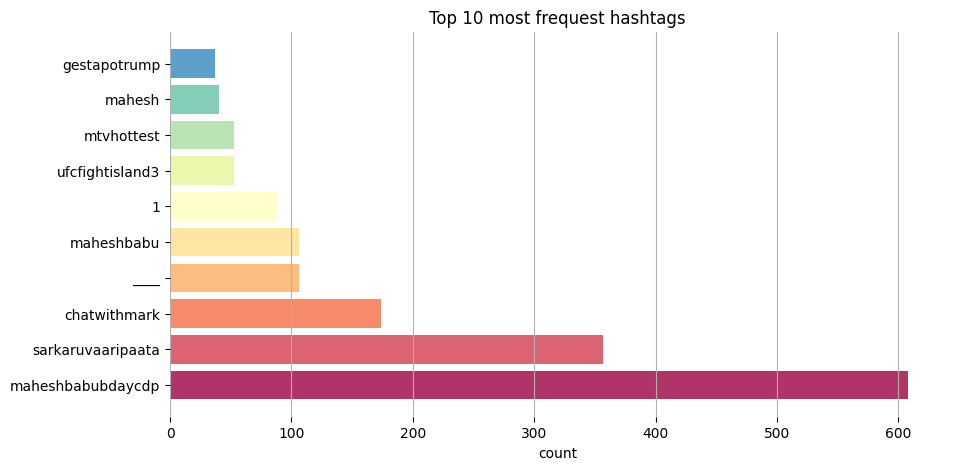

In [13]:
topn = hashtag_frequency[:10]
tags = [val[0] for val in topn]
counts = [val[1] for val in topn]
colors = [plt.cm.Spectral(i / float(len(tags))) for i in range(len(tags))]

plt.rcdefaults()
plt.rcParams["figure.figsize"] = [10, 5]
fig, ax = plt.subplots()
ax.barh(range(len(topn)), counts, align="center", color=colors, alpha=0.8)
plt.yticks(range(len(topn)), tags)
ax.set_xlabel("count")
ax.set_title("Top {n} most frequest hashtags".format(n=len(topn)))
ax.xaxis.grid(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.show()

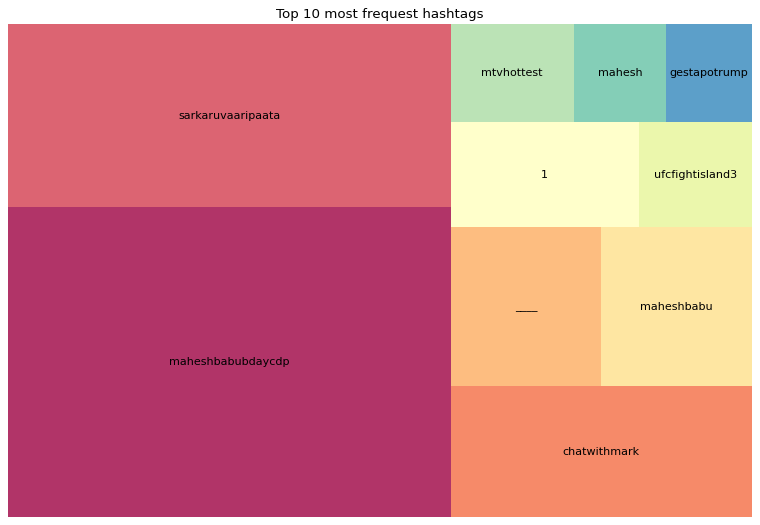

In [14]:
plt.figure(figsize=(12, 8), dpi=80)
squarify.plot(sizes=counts, label=tags, color=colors, alpha=0.8)

plt.title("Top {n} most frequest hashtags".format(n=len(topn)))
plt.axis("off")
plt.show()

In [15]:
cursor.close()
connection.close()